In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np

import calibpy.calibration as calib

SCREEN_WH = (1920, 1080)
FRAME_RATE = 20

In [2]:
# Split video into image frames
notebook_path = os.path.dirname(os.path.realpath('__file__'))
video_path = os.path.join(notebook_path, '..', 'res/checkerboard.mp4')
frames = calib.convert_video_to_frames(video_path, frame_rate=int((1/FRAME_RATE)*1000), save_imgs=False)
print(len(frames))

179


In [3]:
# Display first frame
calib.display_image(frames[0], SCREEN_WH)

In [4]:
# Select initial tracking points (minimum of 4 if later DLT) and track them across frames
points_frames = calib.track_points_seq(frames, SCREEN_WH)

In [5]:
# [Optional] Save video displaying tracked points accross frames
track_video_path = os.path.join(notebook_path, '..', 'res/checkerboard_track.mp4')
calib.convert_frames_to_video(track_video_path, frames, points_frames, frame_rate=FRAME_RATE)
calib.display_video(track_video_path, SCREEN_WH)

In [6]:
# Estimate homography 1st frame
board_points = calib.generate_homogeneous_board_points()
H_0 = calib.estimate_homography(points_frames[0], board_points)

In [7]:
# Reproject checkerboard points and calculate XY pixel error 1st frame
new_image_points = np.matmul(H_0, board_points.T).T
new_image_points = new_image_points[:, 0:2] / new_image_points[:, 2:3]
proj_err = np.mean(np.abs(new_image_points-points_frames[0]), axis=0)
print(proj_err)

[0.74586571 0.50181844]


In [8]:
# Estimate homography from video points to projected image dimensions
proj_image_path = os.path.join(notebook_path, '..', 'res/portal.png')
proj_image = calib.read_image(proj_image_path)
image_dims = tuple(proj_image.shape[0:2][::-1])
proj_image_coords = calib.generate_eqspaced_image_points(image_dims[0], image_dims[1])
homogeneous_points_frame = np.hstack((points_frames[0], np.ones((points_frames[0].shape[0], 1))))
Hproj_0 = calib.estimate_homography(proj_image_coords, homogeneous_points_frame)

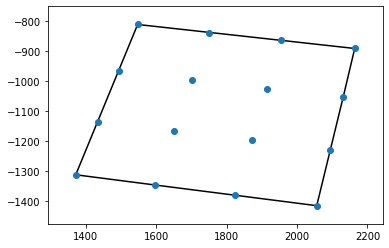

In [9]:
# Find points that form region of tracked points 1st frame
int_points = calib.calculate_interior_points(points_frames[0], plot_hull=True)

In [10]:
# Project image onto original video 1st frame
new_image = calib.project_image(frames[0], proj_image, int_points, Hproj_0)
calib.display_image(new_image, SCREEN_WH)

In [12]:
# [Optional] Save video displaying projected image across frames
mod_images = np.zeros(frames.shape, dtype=np.uint8)
mod_video_path = os.path.join(notebook_path, '..', 'res/checkerboard_mod.mp4')
for idx in tqdm(range(points_frames.shape[0])):
    homogeneous_points_frame = np.hstack((points_frames[idx], np.ones((points_frames[idx].shape[0], 1))))
    Hproj = calib.estimate_homography(proj_image_coords, homogeneous_points_frame)
    int_points = calib.calculate_interior_points(points_frames[idx], plot_hull=False)
    mod_image = calib.project_image(frames[idx], proj_image, int_points, Hproj)
    mod_images[idx] = mod_image
calib.convert_frames_to_video(mod_video_path, mod_images, frame_rate=FRAME_RATE)
calib.display_video(mod_video_path, SCREEN_WH)

  0%|          | 0/179 [00:00<?, ?it/s]